## Imports:

In [11]:
import numpy as np 
import cv2 as cv
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

## Loading in the 5k oxford dataset:

In [3]:
def load_image_from_folder(folder):
    images = []
    filenames = []
    y = []
    category, idx = "none", 0
    for filename in sorted(os.listdir(folder)):
        if filename.endswith(".jpg"):
            image = cv.imread(os.path.join(folder, filename))
            gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
            if gray_image is not None:
                images.append(gray_image)
                split_name = filename.split('_')
                if len(split_name) == 3:
                    fname = filename.split('_')[0] + "_" + filename.split('_')[1]
                elif len(split_name) == 2:
                    fname = filename.split('_')[0]
                filenames.append(fname)
                if filename.startswith(category):
                    y.append(idx)
                else:
                    split = filename.split('_')
                    if len(split) == 3:
                        category = filename.split('_')[0] + "_" + filename.split('_')[1]
                    elif len(split) == 2:
                        category = filename.split('_')[0]
                    idx = idx + 1
                    y.append(idx)                    
    return images, filenames, y

folder = r"C:\Users\Sean\Desktop\Image-Retrieval\Oxford code\Oxford dataset\Oxford building images"
images, filenames, y = load_image_from_folder(folder)
print(len(images), len(filenames), len(y))

5063 5063 5063


## Solving descriptor and keypoints on all images

In [4]:
def SIFT(images):
    sift = cv.SIFT_create()
    
    keypoints_per_image = []
    descriptor_per_image = []
    
    count = 0
    for image in images:
        keypoints, descriptor = sift.detectAndCompute(image, None)

        keypoints_per_image.append(keypoints)
        descriptor_per_image.append(descriptor)
        
        count += 1 
        clear_output(wait=True)
        print("Percentage Completed: {}%".format(round((count/len(images))*100), 2))
    
    return keypoints_per_image, descriptor_per_image

keypoints_per_image, descriptor_per_image = SIFT(images)

Percentage Completed: 100%


In [5]:
print(len(keypoints_per_image), len(descriptor_per_image))

5063 5063


## Saving the data to .npy files

In [30]:
np.save('images.npy', images)
np.save('filenames.npy', filenames)
np.save('y', y)
np.save('descriptor_per_image.npy', descriptor_per_image)

C:\Users\Sean\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


TypeError: cannot pickle 'cv2.KeyPoint' object

## Loading in .npy files

In [4]:
images = np.load('images.npy', allow_pickle=True)
filenames = np.load('filenames.npy')
y = np.load('y.npy')
descriptor_per_image = np.load('descriptor_per_image.npy', allow_pickle=True)

## Reshaping the descriptors into 2D array


In [6]:
stack = []
for desc in descriptor_per_image:
    tmp = np.array(desc)
    if tmp.shape:
        stack.append(tmp)
all_descriptors = np.vstack(i for i in stack)

<ipython-input-6-9d25f1ca9b91>:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  all_descriptors = np.vstack(i for i in stack)


In [7]:
print(all_descriptors.shape)

(17828282, 128)


## Creating a Bag of Words using descriptors

In [18]:
from sklearn.cluster import KMeans

# Should i break up the descriptors into test and training set, as the query images (test set) will have their own descriptors
# already in the cluster. This means new data will find the nearest ones and not itself!

# How many clusters do we set?
# Will this not be a HUGE!!!! clustering algorithm?
# Do we use AKM or HKM instead? - research how to do this instead? - paper says AKM is better

# HKM:
# Split kmeans with k amount of clusters:
# Using these k clusters split their data into another k amount of clusters using kmeans
# Can do this recursively until satisfied amount of clusters
# Q's:
# How do we predict new queries then or do we run it with all the descriptors (no test train split)

kmeans = KMeans(n_clusters=1000000) # Should use 1M visual words (what the paper said) (thats so large though?)
kmeans.fit(all_descriptors) # this has a length of nearly 18M!!

# Use to see which visual word a given keypoint descriptor is closest to!
#######kmeans.predict(input)

# Do we then make an array of which visual words the image (keypoints) hold (it will be the length of n_clusters - like a histogram)
# Then we use this array to compare across other images (run it into our image retrieval code)?
# Finding Euclidean distance between these arrays?

# Also what is Spatial re-ranking? I don't really understand what its going on about

MemoryError: Unable to allocate 8.50 GiB for an array with shape (17828282, 128) and data type float32

## Using cv2 bag of visual words model:

Used sites:https://towardsdatascience.com/bag-of-visual-words-in-a-nutshell-9ceea97ce0fb
https://stackoverflow.com/questions/51168896/bag-of-visual-words-implementation-in-python-is-giving-terrible-accuracy
https://scikit-learn.org/stable/modules/clustering.html#k-means


In [22]:
from sklearn.cluster import MiniBatchKMeans # Apparently better than kmeans (slightly worser results but faster speed)

In [25]:
def cluster(data, n_clusters=100):
    start = time.time()

    mbkm = MiniBatchKMeans(n_clusters=n_clusters)
    y_mbkm = mbkm.fit_predict(data)

    end = time.time()
    print("Time Elapsed: {} min".format(round((end - start)/60, 2)))
    return y_mbkm

mbkm.n_iter_ -> to show how many iterations the model performed
kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state=42) -> use init = '' for time testing
y_kmeans = kmeans.fit_predict(X) -> fits and predicts all the points already! (could save time)

In [26]:
y_mbkm_100 = cluster(all_descriptors, 100)

Time Elapsed:  697.4753751754761


In [48]:
def find_image_histograms(descriptors_per_image, y_mbkmeans, n_clusters):
    previous = 0
    count = 0
    image_words = []
    for image_number in range(len(descriptors_per_image)):
        if descriptors_per_image[image_number] is not None:
            number_of_keypoints = len(descriptors_per_image[image_number])
            image_words.append(y_mbkmeans[previous:number_of_keypoints+previous])
            previous = number_of_keypoints
            
            count += 1
            clear_output(wait=True)
            print("(1/2) Percentage Completed: {}%".format(round((count/len(descriptors_per_image))*100), 2))

    count = 0
    image_histograms = []
    for image in range(len(image_words)):
        hist = [0]*n_clusters
        for words in image_words[image]:
            hist[words-1] = hist[words-1]+1
        image_histograms.append(hist)
        
        count += 1
        clear_output(wait=True)
        print("(2/2) Percentage Completed: {}%".format(round((count/len(image_words))*100), 2))
    
    return image_histograms

In [49]:
oxford_5k_image_histograms = find_image_histograms(descriptor_per_image, y_mbkm_100, 100)

(2/2) Percentage Completed: 100%


In [55]:
np.save('BoW_features_words=100.npy', oxford_5k_image_histograms)

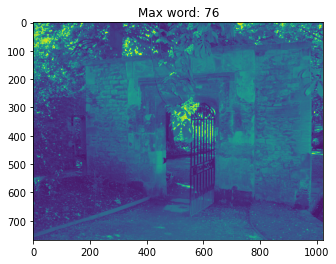

In [73]:
def display_image_max_word(images, image_number=0):
    plt.imshow(images[image_number])

    max_number = 0
    for i in range(len(oxford_5k_image_histograms[image_number])):
        if oxford_5k_image_histograms[image_number][i] > max_number:
            max_index = i
            max_number = oxford_5k_image_histograms[image_number][i]

    plt.title("Max word: " + str(max_index+1))
    plt.show()

display_image_max_word(images, 5000)

## Code to complete histograms for x amount of visual words

In [77]:
n_clusters = 10000

y_mbkm_nclusters = cluster(all_descriptors, n_clusters)

Time Elapsed:  1780.795666217804


In [78]:
oxford_5k_image_histograms = find_image_histograms(descriptor_per_image, y_mbkm_nclusters, n_clusters)
np.save('BoW_features_words={}.npy'.format(n_clusters), oxford_5k_image_histograms)

(2/2) Percentage Completed: 100%


## SIFT for MPEG7 dataset:

In [ ]:
# Extracting images etc
folder = r"C:\Users\Sean\Desktop\Image-Retrieval\Oxford code\Oxford dataset\Oxford building images"
images, filenames, y = load_image_from_folder(folder)
print(len(images), len(filenames), len(y))

In [ ]:
# solving keypoints and descriptors
keypoints_per_image, descriptor_per_image = SIFT(images)

In [ ]:
# putting descriptors into 1 array
stack = []
for desc in descriptor_per_image:
    tmp = np.array(desc)
    if tmp.shape:
        stack.append(tmp)
all_descriptors = np.vstack(i for i in stack)
print(all_descriptors.shape)

In [ ]:
# Clustering
n_clusters = 10000
y_mbkm_nclusters = cluster(all_descriptors, n_clusters)

In [ ]:
# Computing histograms and saving to .npy file
oxford_5k_image_histograms = find_image_histograms(descriptor_per_image, y_mbkm_nclusters, n_clusters)
np.save('BoW_features_words={}.npy'.format(n_clusters), oxford_5k_image_histograms)